## Part 1 - Produce Data
We elected to use the datagen connector to generate fake data for this assignment. The topic we used was 'stocktrades. The steps were as follows:
*  Open a browser and go to http://localhost:9021/
*  Select the available cluster
*  On the menu bar, select Connect
*  Click on the connect-default cluster in the Connect Clusters list.
*  Click on Add connector
*  Select DatagenConnector
*  Enter connector_stock_trades in the Name field

Then:
Generate a data stream with following configurations:
```
{
  "name": "connector_stock_trades",
  "connector.class": "io.confluent.kafka.connect.datagen.DatagenConnector",
  "key.converter": "org.apache.kafka.connect.storage.StringConverter",
  "kafka.topic": "stocktrades",
  "max.interval": "100",
  "quickstart": "Stock_Trades"
}
```


## Part 2 - Using Ksql to create at least 2 streams with filtering from topics

To begin, you need to create a stream called stocktrades with no filtering in place.

### Create JSON Stream
In order for this to play nicely with spark, we need to mimic the raw stream as a json formatted stream.

### Stream 1 - Sell Stream
It may be in the interest of the business to view only streams where the stock was sold and not bought. This would be useful in identifying which shares should be taken as a 'short' position

### Stream 2 - Buy Stream
It may also be interesting to the business to see trades that were large buys.

### Table 1 - Aggregated Buy Trades


### Table 2 - Aggregated Sell Trades

## Part 3 - Consume/Transform data with Spark Streaming

### Set up Spark Session

In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StringType, StructField, IntegerType, FloatType, BinaryType

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
spark.version

'3.1.1'

In [4]:
spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()

'3.2.0'

## Building a Stream
The code below just walks through how the stream is built. A streamlined function is built for part 3a below.

Firstly, we need to connect to our raw JSON stream 'STOCKTRADES_JSON'.

In [5]:
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "STOCKTRADES_JSON") \
  .load()

In [6]:
stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



create a stream to view the output.

In [7]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrades_view") \
    .start()

In [8]:
clear_output(wait=True)
display(spark.sql('SELECT key, value FROM raw_stocktrades_view').show(20))
time.sleep(1)

+---+-----+
|key|value|
+---+-----+
+---+-----+



None

Despite the key being NULL, the key is equivalent to the `value.symbol` field as shown in confluent. We are happy to proceed without this data.

In [9]:
raw_stream.stop()

### Convert Key Value pairs to strings
Converting to strings allows us to read the actual content of the key and value. Above the values are in hexadecimal binary, which doesnt make sesne to a human.

In [12]:
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
      .withColumn('value', stream_df["value"].cast(StringType()))

In [13]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrades_view") \
    .start()

In [15]:
clear_output(wait=True)
display(spark.sql('SELECT key, value FROM string_stocktrades_view').show(20))
time.sleep(1)

+----+--------------------+
| key|               value|
+----+--------------------+
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
+----+--------------------+
only showing top 20 rows



None

In [16]:
string_stream.stop()

## Transformation

For future parts, we will need the data in a tidy format, not a JSON format. To do this, we need to outline the JSON structure of the data. and use the inbuilt `from_json` function from Spark to read in the data.

In [17]:
schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
         StructField("USERID", StringType(), True)
])

In [18]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))

In [19]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- SIDE: string (nullable = true)
 |    |-- QUANTITY: integer (nullable = true)
 |    |-- PRICE: integer (nullable = true)
 |    |-- SYMBOL: string (nullable = true)
 |    |-- ACCOUNT: string (nullable = true)
 |    |-- USERID: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [20]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_stocktrades_view") \
    .start()

In [24]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_stocktrades_view').show(20, False))
time.sleep(1)

+----+----------------------------------------+----------------+---------+------+-----------------------+-------------+
|key |value                                   |topic           |partition|offset|timestamp              |timestampType|
+----+----------------------------------------+----------------+---------+------+-----------------------+-------------+
|null|{BUY, 1934, 893, ZTEST, ABC123, User_8} |STOCKTRADES_JSON|0        |0     |2021-06-11 00:40:34.802|0            |
|null|{SELL, 1401, 379, ZVV, ABC123, User_4}  |STOCKTRADES_JSON|0        |1     |2021-06-11 00:40:34.837|0            |
|null|{SELL, 2310, 848, ZJZZT, LMN456, User_6}|STOCKTRADES_JSON|0        |2     |2021-06-11 00:40:34.897|0            |
|null|{BUY, 35, 845, ZWZZT, LMN456, User_2}   |STOCKTRADES_JSON|0        |3     |2021-06-11 00:40:34.989|0            |
|null|{BUY, 3883, 503, ZBZX, ABC123, User_8}  |STOCKTRADES_JSON|0        |4     |2021-06-11 00:40:35.077|0            |
|null|{SELL, 2137, 88, ZWZZT, ABC123, Us

None

In [25]:
json_stream.stop()

### Flatten Data
Finally, we need to separate the data that is in the value field into individual columns.

In [26]:
stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )

In [27]:
stocktrades_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- side: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- account: string (nullable = true)
 |-- userid: string (nullable = true)



In [28]:
stocktrades_stream = stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrades_view") \
    .start()

In [32]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrades_view').show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    1934|  893| ZTEST| ABC123|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    1401|  379|   ZVV| ABC123|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    2310|  848| ZJZZT| LMN456|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|      35|  845| ZWZZT| LMN456|User_2|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    3883|  503|  ZBZX| ABC123|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    2137|   88| ZWZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    3459|   21|  ZBZX| XYZ789|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|     828|  253|  ZBZX| XYZ

None

In [33]:
stocktrades_stream.stop()

## Part 3a - Build at least 2 Spark Streaming dataframes
This function generates a stream from stocktrades with one line of code so its easier to call in later components. It is equivalent to the structure outlined above. 

In [5]:
def generate_stocktrades_stream(keep_stream = False):
    
    # Define the raw Spark Stream
    stream_df = spark \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("startingOffsets", "latest") \
      .option("subscribe", "STOCKTRADES_JSON") \
      .load()
    
    # Convert to string types for JSON conversion
    string_stream_df = stream_df \
        .withColumn("key", stream_df["key"].cast(StringType())) \
        .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema for the end JSON format
    schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
        StructField("USERID", StringType(), True)
])
    # Convert the string type to json format stream
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    
    # Export a queryable view od the stream
    
    if not keep_stream:
        return stocktrades_stream_df \
        .writeStream \
        .format("memory") \
        .queryName("stocktrades_view") \
        .start()
    else:
        return stocktrades_stream_df \
        .writeStream \
        .format("memory") \
        .queryName("stocktrades_view") \
        .start(), stocktrades_stream_df

In [11]:
stocktrades_stream = generate_stocktrades_stream()

In [12]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrades_view').show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 07:09:...| BUY|    3765|  589| ZJZZT| ABC123|User_7|
|     null|STOCKTRADES_JSON|2021-06-11 07:09:...|SELL|    1090|  207| ZVZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 07:09:...|SELL|    1387|  942| ZTEST| ABC123|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 07:09:...|SELL|    2727|  902| ZWZZT| LMN456|User_6|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+



None

In [13]:
stocktrades_stream.stop()

### Second Query

In [14]:
# Create function to stream filtered streams from Kafka as streaming dataframes
def generate_side_stream(SIDE):
    '''
    This function generates a stream for the BUY and SELL topics.
    
    @param SIDE: 'BUY' OR 'SELL' streams.
    
    Returns:
    Spark DataFrame
    '''
    # Create string for source
    source_stream = SIDE + "_TRADES"
    # Define the raw Spark Stream
    
    stream_df = spark \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("startingOffsets", "latest") \
      .option("subscribe", source_stream) \
      .load()
    
    # Convert to string types for JSON conversion
    string_stream_df = stream_df \
        .withColumn("key", stream_df["key"].cast(StringType())) \
        .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema for the end JSON format
    schema_stocktrades =  StructType([
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
        StructField("USERID", StringType(), True)
])
    # Convert the string type to json format stream
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    
    # Export a queryable view od the stream
    return stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName(SIDE + '_view') \
    .start()

In [15]:
# Create views of the buy and sell streams
BUY_stream = generate_side_stream('BUY')
SELL_stream = generate_side_stream('SELL')

In [16]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql('SELECT * FROM BUY_view').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------+-----+------+-------+------+
|event_key|event_topic|     event_timestamp|quantity|price|symbol|account|userid|
+---------+-----------+--------------------+--------+-----+------+-------+------+
|     null| BUY_TRADES|2021-06-11 07:09:...|    2366|  269| ZJZZT| ABC123|User_6|
|     null| BUY_TRADES|2021-06-11 07:09:...|    2677|  997| ZJZZT| LMN456|User_7|
|     null| BUY_TRADES|2021-06-11 07:09:...|    1417|  236| ZTEST| LMN456|User_5|
|     null| BUY_TRADES|2021-06-11 07:09:...|    4237|  906|  ZBZX| ABC123|User_9|
|     null| BUY_TRADES|2021-06-11 07:09:...|    1884|  739| ZWZZT| LMN456|User_7|
|     null| BUY_TRADES|2021-06-11 07:09:...|    2545|  576| ZVZZT| XYZ789|User_2|
|     null| BUY_TRADES|2021-06-11 07:09:...|    1073|  772| ZTEST| LMN456|User_3|
|     null| BUY_TRADES|2021-06-11 07:09:...|    4572|  993|  ZBZX| ABC123|User_1|
+---------+-----------+--------------------+--------+-----+------+-------+------+



None

In [17]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql('SELECT * FROM SELL_view').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------+-----+------+-------+------+
|event_key|event_topic|     event_timestamp|quantity|price|symbol|account|userid|
+---------+-----------+--------------------+--------+-----+------+-------+------+
|     null|SELL_TRADES|2021-06-11 07:09:...|    1116|  578| ZTEST| ABC123|User_1|
|     null|SELL_TRADES|2021-06-11 07:09:...|    2942|  172| ZVZZT| LMN456|User_7|
|     null|SELL_TRADES|2021-06-11 07:09:...|    4191|  254| ZVZZT| ABC123|User_1|
|     null|SELL_TRADES|2021-06-11 07:09:...|    2499|  802| ZWZZT| LMN456|User_5|
|     null|SELL_TRADES|2021-06-11 07:09:...|    3006|  280| ZWZZT| LMN456|User_3|
|     null|SELL_TRADES|2021-06-11 07:09:...|     236|  429| ZVZZT| XYZ789|User_6|
|     null|SELL_TRADES|2021-06-11 07:09:...|    3329|  270|  ZBZX| ABC123|User_6|
|     null|SELL_TRADES|2021-06-11 07:09:...|    3458|  871| ZVZZT| ABC123|User_6|
|     null|SELL_TRADES|2021-06-11 07:09:...|    2769|  912|   ZVV| LMN456|User_2|
|     null|SELL_

None

In [18]:
# Stop the two streams
BUY_stream.stop()
SELL_stream.stop()

## Part 3b - Build 1 window stream with a watermark

In [19]:
# Restart the raw data data frame
raw_stream, raw_stream_df = generate_stocktrades_stream(True)

# Create parameters for the window stream
window_duration = '60 seconds'
slide_duration = '10 seconds'
time.sleep(10)

#### Create Windowed Stream
this groups by symbol and then counts the numbers of trades in the window, quantity of shares traded and the average price traded

In [20]:
windowed_agg_df = raw_stream_df \
    .withWatermark('event_timestamp', '1 minutes') \
    .groupBy(F.window(raw_stream_df.event_timestamp, window_duration, slide_duration), raw_stream_df.symbol) \
    .agg(F.count('SYMBOL').alias('no_trades'), \
    F.sum('QUANTITY').alias('tot_quantity'), \
    F.avg('PRICE').alias('avg_price') \
     )

In [21]:
# Export the stream as a qeuryable view
windowed_agg_stream = windowed_agg_df \
                        .writeStream \
                        .format("memory") \
                        .outputMode("Complete") \
                        .queryName("windowed_view") \
                        .start()

In [22]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM windowed_view').show())
time.sleep(1)

+--------------------+------+---------+------------+------------------+
|              window|symbol|no_trades|tot_quantity|         avg_price|
+--------------------+------+---------+------------+------------------+
|{2021-06-11 07:09...| ZVZZT|       37|       96950| 524.2162162162163|
|{2021-06-11 07:08...|  ZBZX|       10|       25396|             492.2|
|{2021-06-11 07:09...|  ZBZX|       38|       99824|482.07894736842104|
|{2021-06-11 07:08...|   ZVV|       16|       37495|          522.5625|
|{2021-06-11 07:09...| ZTEST|       42|       93913| 541.3809523809524|
|{2021-06-11 07:09...| ZXZZT|       51|      142049| 440.2549019607843|
|{2021-06-11 07:09...| ZWZZT|       38|      100884| 549.7631578947369|
|{2021-06-11 07:09...|  ZBZX|       39|      103859| 477.7435897435897|
|{2021-06-11 07:09...| ZWZZT|       36|       95099| 537.5833333333334|
|{2021-06-11 07:09...| ZWZZT|       38|      100884| 549.7631578947369|
|{2021-06-11 07:09...| ZTEST|       42|       93913| 541.3809523

None

In [23]:
raw_stream.stop()

In [24]:
windowed_agg_stream.stop()

## Part 3c - Build at least 1 spark query
A number of other spark queries have been built above. For the flow, I have included a new spark query here.

In [25]:
stocktrade_stream_df = generate_stocktrades_stream()

In [26]:
query = "select * from stocktrades_view WHERE price > 800"

In [27]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql(query).show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON| 2021-06-11 07:10:19| BUY|    3239|  976|   ZVV| LMN456|User_1|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...| BUY|    1703|  963|   ZVV| LMN456|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...|SELL|    3653|  801|  ZBZX| LMN456|User_3|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...| BUY|    1273|  813|  ZBZX| LMN456|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...| BUY|    3885|  988| ZWZZT| LMN456|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...|SELL|    1337|  972|  ZBZX| XYZ789|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...|SELL|    2297|  832| ZWZZT| ABC123|User_3|
|     null|STOCKTRADES_JSON|2021-06-11 07:10:...| BUY|    1070|  985|   ZVV| LMN

None

In [28]:
stocktrade_stream_df.stop()

## Part 3d - Export your spark queries into parquets stocktrade_stream
Create the stream and write into the `parquet_output` folder in the data folder.

In [29]:
stocktrade_stream_df, raw_stream_df = generate_stocktrades_stream(True)

In [30]:
raw_stream_df.writeStream \
                .format("parquet") \
                .option("header", True) \
                .option("path", "../data/parquet_output") \
                .option("checkpointLocation", "checkpoint/data") \
                .outputMode("append") \
                .trigger(once=True) \
                .start()

In [42]:
stocktrade_stream_df.stop()

## Part 3e - build at least 1 visualisation which will be refreshed at regular interval

In [6]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline
from pyspark.sql.functions import desc

In [7]:
def visualise(x = 10, sleep = 5):
    '''
    Function to create and update function as data streams in. Note that this function is set to update 10 times
    Parameters:
    @param x: Number of iterations for the chart to update
    @param sleeep: Seconds between chart updates
    
    '''
    stocktrades_stream_df= generate_stocktrades_stream()
    count = 0
    while count <= x:

        time.sleep(sleep)
        top_10_users = spark.sql('Select userid,sum(quantity) as quantity from stocktrades_view group by userid order by quantity desc limit 10' 
    )
        top_10_df = top_10_users.toPandas()
        display.clear_output(wait=True)
        plt.figure( figsize = ( 10, 8 ) )
        sns.barplot( x="quantity", y="userid", data=top_10_df)
        plt.show()
        count = count + 1
        print(f'Count:{count}')
    stocktrades_stream_df.stop()

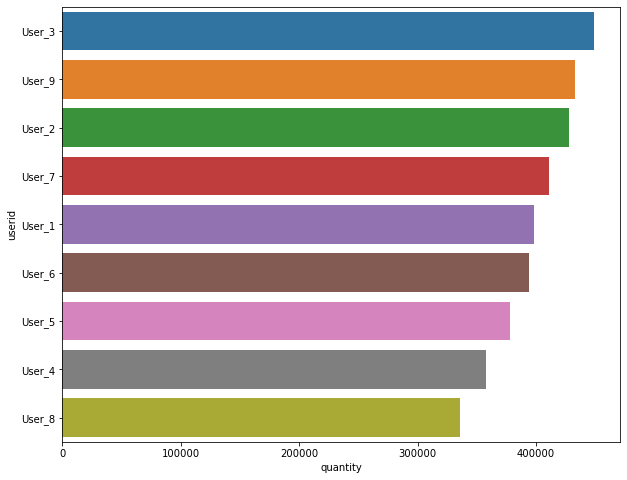

Count:11


In [8]:
visualise()

## Part 4 - Build ML model
We believe it would be useful to predict whether a trade was a buy or sell trade based on the quantity, price account and stock code. The following code follows a similar pattern to that outlined in assignment 1.

### Read Data from Parquet Sink
Note that when you read in the parquet file you need to set the option `mergedSchema` to `true` this is because the parquet sink is actually a collection of parquet files, not a singular parquet file.

In [6]:
parquetFile = spark.read.option("mergeSchema", "true").parquet("../data/parquet_output")

In [7]:
parquetFile.describe().show()


+-------+---------+----------------+------+------------------+------------------+------+-------+------+
|summary|event_key|     event_topic|  side|          quantity|             price|symbol|account|userid|
+-------+---------+----------------+------+------------------+------------------+------+-------+------+
|  count|        0|          215453|215453|            215453|            215453|215453| 215453|215453|
|   mean|     null|            null|  null| 2501.367165924819| 501.9253851187962|  null|   null|  null|
| stddev|     null|            null|  null|1443.2353946422181|287.13652806540324|  null|   null|  null|
|    min|     null|STOCKTRADES_JSON|   BUY|                 1|                 5|  ZBZX| ABC123|User_1|
|    max|     null|STOCKTRADES_JSON|  SELL|              4999|               999| ZXZZT| XYZ789|User_9|
+-------+---------+----------------+------+------------------+------------------+------+-------+------+



In [8]:
cat_cols = ['symbol','account','userid']
cols = ["side",'quantity','price','symbol','account','userid']

In [9]:
df = parquetFile.select(cols)

### Generate data pipeline
In this section, we will encode categorical variables and assemble them using the vector assembler into a pipeline for modelling.

In [10]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [11]:
stages = []
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"], outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [12]:
num_cols = ["quantity","price"]

In [13]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [14]:
assembler = VectorAssembler(inputCols=cat_cols_ohe + num_cols, outputCol="features")

In [15]:
stages += [assembler]


In [16]:
from pyspark.ml import Pipeline

In [17]:
pipeline = Pipeline(stages=stages)

### Build X Column

In [18]:
df.show(5)

+----+--------+-----+------+-------+------+
|side|quantity|price|symbol|account|userid|
+----+--------+-----+------+-------+------+
|SELL|    4862|  443|   ZVV| XYZ789|User_6|
|SELL|     933|  190| ZTEST| ABC123|User_4|
|SELL|    1127|  136| ZVZZT| XYZ789|User_8|
|SELL|    4565|  993| ZWZZT| LMN456|User_7|
| BUY|    3645|  299| ZWZZT| ABC123|User_6|
+----+--------+-----+------+-------+------+
only showing top 5 rows



In [19]:
pipeline_model = pipeline.fit(df)

In [20]:
df = pipeline_model.transform(df)

In [21]:
df.show(5)

+----+--------+-----+------+-------+------+----------+-------------+-----------+-------------+----------+-------------+--------------------+
|side|quantity|price|symbol|account|userid|symbol_ind|   symbol_ohe|account_ind|  account_ohe|userid_ind|   userid_ohe|            features|
+----+--------+-----+------+-------+------+----------+-------------+-----------+-------------+----------+-------------+--------------------+
|SELL|    4862|  443|   ZVV| XYZ789|User_6|       0.0|(6,[0],[1.0])|        0.0|(2,[0],[1.0])|       0.0|(8,[0],[1.0])|(18,[0,6,8,16,17]...|
|SELL|     933|  190| ZTEST| ABC123|User_4|       2.0|(6,[2],[1.0])|        2.0|    (2,[],[])|       3.0|(8,[3],[1.0])|(18,[2,11,16,17],...|
|SELL|    1127|  136| ZVZZT| XYZ789|User_8|       5.0|(6,[5],[1.0])|        0.0|(2,[0],[1.0])|       1.0|(8,[1],[1.0])|(18,[5,6,9,16,17]...|
|SELL|    4565|  993| ZWZZT| LMN456|User_7|       4.0|(6,[4],[1.0])|        1.0|(2,[1],[1.0])|       5.0|(8,[5],[1.0])|(18,[4,7,13,16,17...|
| BUY|    364

##### Save model for later use

In [65]:
pipeline_model.save('../models/pipeline_model')

In [26]:
from pyspark.ml.feature import StandardScaler

In [22]:
df = df.select(['features','side'])

In [23]:
df.show(5)

+--------------------+----+
|            features|side|
+--------------------+----+
|(18,[0,6,8,16,17]...|SELL|
|(18,[2,11,16,17],...|SELL|
|(18,[5,6,9,16,17]...|SELL|
|(18,[4,7,13,16,17...|SELL|
|(18,[4,8,16,17],[...| BUY|
+--------------------+----+
only showing top 5 rows



### Inspect Fearture Correlation

In [24]:
from pyspark.ml.stat import Correlation

In [27]:
r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n")
print(r1[0])

Pearson correlation matrix:

DenseMatrix([[ 1.00000000e+00, -1.68552011e-01, -1.67671849e-01,
              -1.67643218e-01, -1.67452295e-01, -1.67379083e-01,
               7.21497342e-04, -3.89545087e-05, -2.40880835e-03,
              -1.05990203e-03,  1.41706853e-03, -3.10081123e-03,
               2.58141142e-03,  3.51857396e-03, -7.98421301e-04,
              -1.08290849e-03, -3.63374269e-03, -1.40528436e-04],
             [-1.68552011e-01,  1.00000000e+00, -1.67300279e-01,
              -1.67271712e-01, -1.67081212e-01, -1.67008162e-01,
               1.99464793e-03, -1.15196072e-03, -4.33009692e-04,
               1.29668516e-03,  1.42567289e-03,  7.67284997e-04,
              -1.48993177e-03, -3.53923323e-03,  2.65736573e-03,
               2.24349099e-04,  1.50024546e-03,  1.76119999e-03],
             [-1.67671849e-01, -1.67300279e-01,  1.00000000e+00,
              -1.66398236e-01, -1.66208730e-01, -1.66136062e-01,
              -4.46025191e-03,  5.49654333e-03, -1.33632447

### Scale X Features

X features need to be scaled as we are using logistic regression for our model.

In [29]:
xscaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [30]:
xscalerModel = xscaler.fit(df)

##### Save model for future use

In [37]:
xscalerModel.write().overwrite().save("../models/xscaler")

In [38]:
df = xscalerModel.transform(df)

In [39]:
df.show(5)

+--------------------+----+--------------------+
|            features|side|      scaledFeatures|
+--------------------+----+--------------------+
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|
|(18,[2,11,16,17],...|SELL|(18,[2,11,16,17],...|
|(18,[5,6,9,16,17]...|SELL|(18,[5,6,9,16,17]...|
|(18,[4,7,13,16,17...|SELL|(18,[4,7,13,16,17...|
|(18,[4,8,16,17],[...| BUY|(18,[4,8,16,17],[...|
+--------------------+----+--------------------+
only showing top 5 rows



### Convert Target Variable
The target variable is categorical, and therefore needs to be converted into a binary (1,0) variable. To do this, we use the StringIndexer.

In [40]:
yencoder = StringIndexer(inputCol='side', outputCol="target")

In [41]:
y_coder = yencoder.fit(df)

In [42]:
df = y_coder.transform(df)

##### Save model for future use

In [67]:
y_coder.save('../models/y_coder')

### Split into Training and Test sets

In [43]:
df_train, df_test = df.randomSplit([0.7,0.3], seed = 42)

In [44]:
df_train.show()

+--------------------+----+--------------------+------+
|            features|side|      scaledFeatures|target|
+--------------------+----+--------------------+------+
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|

In [45]:
df_test.show()

+--------------------+----+--------------------+------+
|            features|side|      scaledFeatures|target|
+--------------------+----+--------------------+------+
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|

### Train model

In [46]:
from pyspark.ml.classification import LogisticRegression

As we are training the model on random data, we do not expect a solid result. To ensure probabilities are different from each other, I have set the elasticNet param to 0. This is to ensure that no penalty is applied to the weights of the regression output - flattening the results to 0.

In [49]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0,featuresCol='scaledFeatures', labelCol = 'target')

In [50]:
lrModel = lr.fit(df_train)

## Make Predictions on Training and Test Sets

In [51]:
train_preds_dt = lrModel.transform(df_train)

In [52]:
test_preds_dt = lrModel.transform(df_test)

In [53]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [54]:
test_preds_dt.show(5)

+--------------------+----+--------------------+------+--------------------+--------------------+----------+
|            features|side|      scaledFeatures|target|       rawPrediction|         probability|prediction|
+--------------------+----+--------------------+------+--------------------+--------------------+----------+
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|[-0.0162006184858...|[0.49594993395985...|       1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|[-0.0158202228426...|[0.49604502677636...|       1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|[-0.0186460485016...|[0.49533862292753...|       1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|[-0.0169210430769...|[0.49576984016249...|       1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|[-0.0176108557476...|[0.49559739984852...|       1.0|
+--------------------+----+--------------------+------+--------------------+--------------------+----------+
only showing top 5 

In [55]:
predictionAndLabels = test_preds_dt.rdd.map(lambda lp: (lp.prediction,float(lp.target)))


#### Model Evaluation
As expected, the model performed poorly because we are trying to model random data. The results are essentially a coin flip.

In [56]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

In [57]:
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.5015155950064416


In [58]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [59]:
metrics = MulticlassMetrics(predictionAndLabels)

In [60]:
print(metrics.confusionMatrix().toArray())

[[18048. 14439.]
 [17823. 14435.]]


##### Save model for future use

In [61]:
lrModel.save("../models/lr_model")

## Part 4b - Deploy Model as New Stream

Since we have used Kafka for part 2, we decided the new stream should feed back into kafka.

In [28]:
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StandardScalerModel
from pyspark.ml.feature import StringIndexerModel

#### Functions
Two functions were created to generate the new stream with predictions.
1. `transform_data` converts the stream into the correct format for the machine learning model.
2. `generate_spark_stream` predicts the result on the stream and then publishes the stream to kafka

In [29]:
def transform_data(input_df):
    '''
    Function to complete all necessary pre-model data transformations. 
    @param input_df: Input data
    
    Returns:
    df (DataFrame): spark dataframe.
    '''
    ## Load Models
    pipeline_model = PipelineModel.load('../models/pipeline_model')
    xscalerModel = StandardScalerModel.load('../models/xscaler')
    y_coder = StringIndexerModel.load('../models/y_coder')
    print("Models Loaded")
    ## Outline Columns
    cat_cols = ['symbol','account','userid']
    cols = ["side",'quantity','price','symbol','account','userid']
    print("DataFrame Subset complete")
    ## Transform data
    df = pipeline_model.transform(input_df)
    print("Variable Cleaning Complete")
    df = xscalerModel.transform(df)
    print("X variables scaled")
    df = y_coder.transform(df)
    print("Complete")
    return df

    

In [30]:
def generate_spark_stream(input_df, cols):
    '''
    This function predicts the output on the data stream and writes back into Kafka
    @params input_df: spark streaming dataframe
    @params cols: columns to publish to kafka stream
    
    '''
    ## Load LG Model
    lrModel = LogisticRegressionModel.load("../models/lr_model")
    df = transform_data(input_df)
    df = lrModel.transform(df)
    df \
      .select(F.col('symbol').cast(StringType()).alias('key'),F.to_json(F.struct([F.col(c).alias(c) for c in cols])).alias('value')) \
      .writeStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("checkpointLocation", "checkpoint/data") \
      .option("topic", "prediction_topic") \
      .start()
    print("Stream Created")
    

In [31]:
stocktrade_stream_df, raw_stream_df = generate_stocktrades_stream(True)

In [32]:
cols = [ 'side',
 'quantity',
 'price',
 'symbol',
 'account',
 'userid',
 'probability',
 'prediction']

In [33]:
generate_spark_stream(raw_stream_df, cols)

Models Loaded
DataFrame Subset complete
Variable Cleaning Complete
X variables scaled
Complete
Stream Created


##### Stop the stream

In [158]:
stocktrade_stream_df.stop()